[-1.0150465 -0.4939748j  -1.7717564 -0.06868631j  1.7108628 -0.608603j
 -0.67515826-0.58664477j  1.4093719 +3.9277399j  -0.50363284-5.2394867j
 -2.272981  +2.2920415j   1.7059627 +1.3926793j   0.69906634-2.0964432j
  1.1730163 +1.1515391j  -3.8745625 -1.1495304j   0.9441046 +1.2248219j
  1.8308247 -0.22919798j  2.1179564 +0.22086227j -3.9804294 -2.2250013j
 -3.8770204 +2.8771756j  10.        +0.j         -3.8770204 -2.8771756j
 -3.9804294 +2.2250013j   2.1179564 -0.22086227j  1.8308247 +0.22919798j
  0.9441046 -1.2248219j  -3.8745625 +1.1495304j   1.1730163 -1.1515391j
  0.69906634+2.0964432j   1.7059627 -1.3926793j  -2.272981  -2.2920415j
 -0.50363284+5.2394867j   1.4093719 -3.9277399j  -0.67515826+0.58664477j
  1.7108628 +0.608603j   -1.7717564 +0.06868631j]


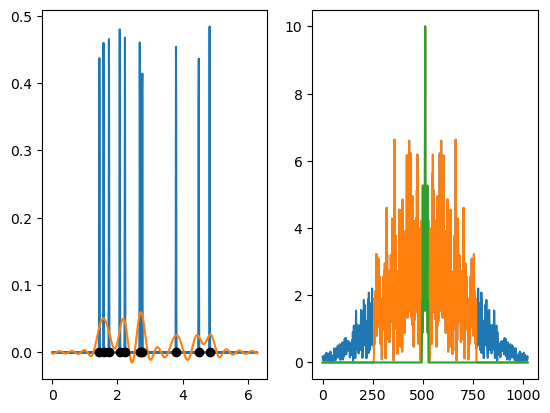

In [103]:
import jax.numpy as jnp
from jax import random, jit, vmap
import matplotlib.pyplot as plt
from jax.numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq

def F(x):
    return fftshift(fft(x))

def get_ks(N):
    return fftshift(fftfreq(N, 1./N))

def iF(x):
    return ifft(ifftshift(x))

def diffuse_ft(x_ft, sigma):
    return x_ft*jnp.exp(-sigma**2*get_ks(len(x_ft))**2/2)

def shift_ft(x_ft, a):
    return x_ft*jnp.exp(-1j*a*get_ks(len(x_ft)))

def dirac_ft(N):
    return jnp.ones((N,))

def smooth_dirac_ft(N, x0, sigma):
    return diffuse_ft(shift_ft(dirac_ft(N), x0), sigma)

def smooth_diracs_ft(N, x0s, sigma):
    return jnp.sum(vmap(lambda x0: smooth_dirac_ft(N, x0, sigma))(x0s), axis=0)

def decimate_ft(x_ft, M, retain_shape=True):
    # Eliminate high frequencies
    N = len(x_ft)
    if retain_shape:
        x_ft = ifftshift(x_ft)
        x_ft = x_ft.at[M:N-M].set(0.) 
        return fftshift(x_ft)
    else:
        return x_ft[N//2-M:N//2+M]

Ndata = 10
Ngrid = 1025
key = random.PRNGKey(0)

t = jnp.linspace(0, 2*jnp.pi, Ngrid+1)[:-1]
x = random.uniform(key, (Ndata,)) * 2*jnp.pi




Fp_x = smooth_diracs_ft(Ngrid, x, 0.005)

p_x = iF(Fp_x).real
p_x2 = iF(decimate_ft(Fp_x, Ngrid//4)).real
p_x4 = iF(decimate_ft(Fp_x, Ngrid//64)).real

print(decimate_ft(Fp_x, Ngrid//64, retain_shape=False))

plt.subplot(121)
plt.plot(t, p_x)
plt.plot(t, p_x4)
plt.scatter(x, x*0, color='k', zorder=10)

plt.subplot(122)
plt.plot(jnp.abs(F(p_x)))
plt.plot(jnp.abs(F(p_x2)))
plt.plot(jnp.abs(F(p_x4)))
